# Vehicle Detection and Tracking

## The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Implement a sliding-window technique and use trained classifier to search for vehicles in images.
3. Run a pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
4. Estimate a bounding box for vehicles detected.


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage.measurements import label

# %matplotlib inline

import warnings #suppressing warnings here because of svc.predict complaining about the size of the input shape
warnings.filterwarnings("ignore") 



### HOG-based SVM Classifier

In [4]:
#some helper functions

#displays images in two colums with given captions (optional)
def display_images_in_2_colums(images, captions=None, cmap=None):
    fig = plt.figure(figsize=(9, 3 * np.ceil(len(images) / 2.)))
    for i in range(len(images)):
        a = fig.add_subplot(np.ceil(len(images) / 2.), 2, i + 1)
        img = images[i]
        plt.imshow(img, cmap=cmap)
        if (not captions is None):
            a.set_title(captions[i])
    plt.show()
    
#HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    return hog(img, 
                orientations=orient, 
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                visualise=vis, 
                feature_vector=feature_vec,
                transform_sqrt=True
                  )

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


#extracts HOG features from given color space and channel
def extract_features(img, cspace='RGB', hog_channel="ALL"):
    # Create a list to append feature vectors to
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    #HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel]))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel])
        
    # Get color features
    spatial_features = bin_spatial(feature_image)
    hist_features = color_hist(feature_image)

    features = np.hstack((spatial_features, hist_features, hog_features))

    return features
    

In [5]:
#loading training data
cars = []
notcars = []
for fl in glob.glob('./training_data/vehicles/KITTI_extracted/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_Far/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_Left/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_Right/*.png'): cars.append(fl)
for fl in glob.glob('./training_data/vehicles/GTI_MiddleClose/*.png'): cars.append(fl)
fl_count = 0
for fl in glob.glob('./training_data/non-vehicles/*.png'):
    notcars.append(fl)
    fl_count += 1
    if (fl_count >= len(cars)):
        break

images = np.ndarray((len(cars) + len(notcars), 64, 64, 3), dtype=np.float32)
labels = np.hstack((np.ones(len(cars), dtype=np.int32), np.zeros(len(notcars), dtype=np.int32)))

i = 0
for fl in cars + notcars:
    img = mpimg.imread(fl)    
    images[i] = img
    i += 1
    
print("{} car images loaded; {} non-car images loaded.".format(len(cars), len(notcars)))

8792 car images loaded; 8792 non-car images loaded.


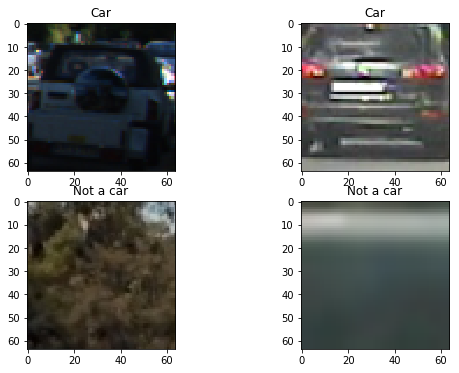

In [6]:
#randomly sampling and displaing 2 of car and non-car images each
display_images = []
captions = []
for i in np.random.random_integers(0, len(cars), 2):
    display_images.append(images[i])
    captions.append("Car")
for i in np.random.random_integers(len(cars), len(labels), 2):
    display_images.append(images[i])
    captions.append("Not a car")
display_images_in_2_colums(display_images, captions)

# print(images[0])

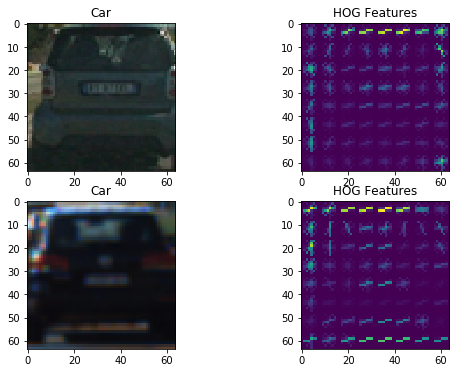

Sample of extracted features: [  2.21085167e+01   1.72500000e+02   4.31249962e+01 ...,   1.14415735e-02
   3.60305338e-02   8.27301306e-02], total number of features per image: 8460


In [7]:
#for some random car samples, extracting their HOG features to see if the filter works
display_images = []
captions = []
for i in np.random.random_integers(0, len(cars), 2):
    display_images.append(images[i])    
    captions.append("Car")
    img = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
    display_images.append(get_hog_features(img, vis=True)[1])
    captions.append("HOG Features")
display_images_in_2_colums(display_images, captions)

features = extract_features(images[0], cspace='HLS')
print("Sample of extracted features: {}, total number of features per image: {}".format(features, len(features)))

In [8]:
#building X set
X = []
for img in images:
    X.append(extract_features(img, cspace='HLS'))
X_Scaler = StandardScaler()
X_Scaler.fit(X)
X = X_Scaler.transform(X)

In [9]:
#splitting into training and test sests
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=rand_state)

In [10]:
#defining and training SVM Classifier
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(3.78, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9909)
('My SVC predicts: ', array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32))
('For these', 10, 'labels: ', array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32))
(0.00092, 'Seconds to predict', 10, 'labels with SVC')


### Sliding window-based search for vehicles in a frame

In [11]:
# Single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, 
              spatial_size=(32,32), hist_bins=32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    detections = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            test_prediction = svc.predict(test_features.reshape(1,-1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                detection = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                detections.append(detection)
                cv2.rectangle(draw_img, detection[0], detection[1], (0,0,255),6) 
                
    return draw_img, detections
    
def add_heat(heatmap, detections):
    # Iterate through list of bboxes
    for box in detections:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

    

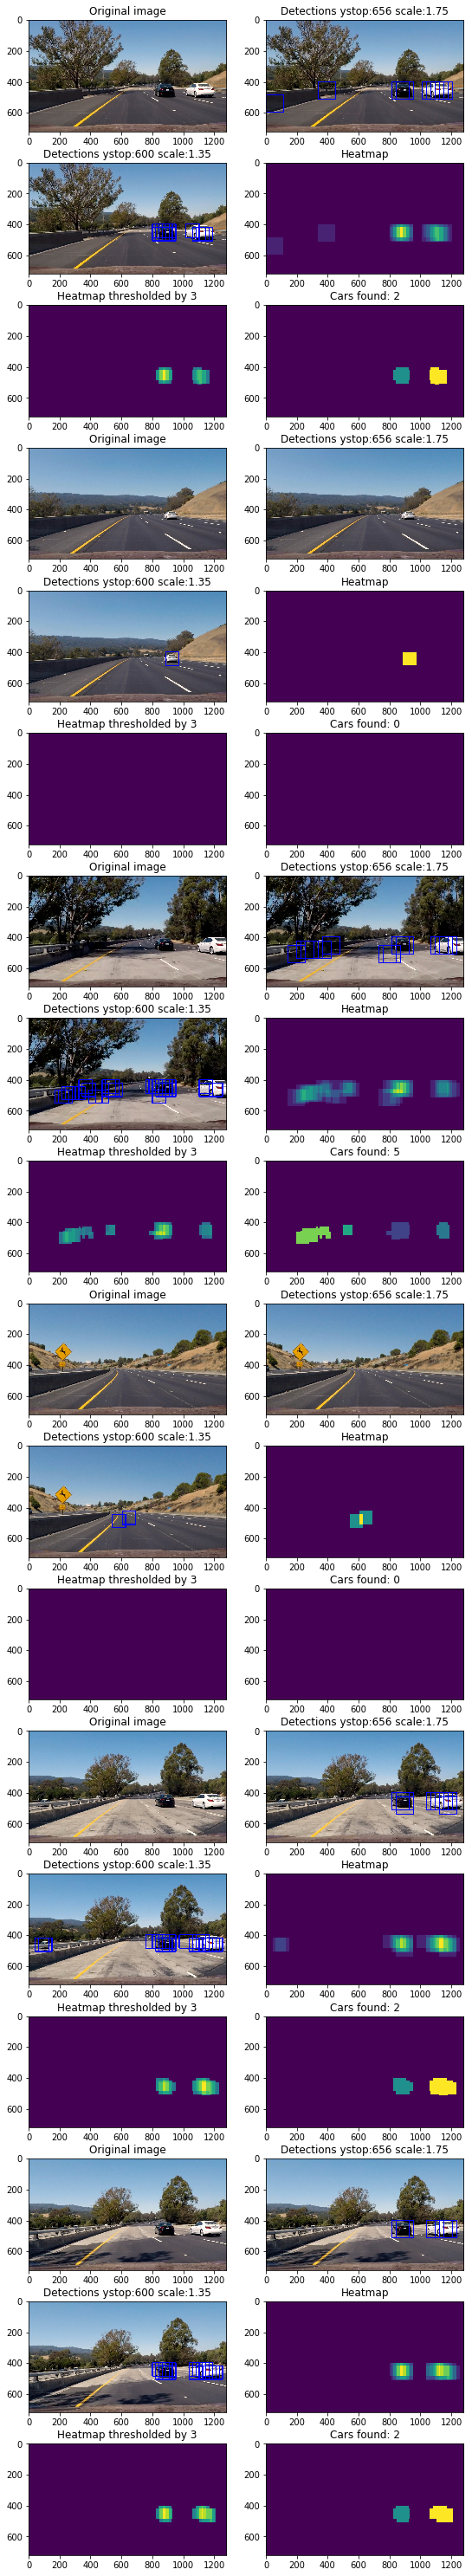

In [12]:
display_images = []
captions = []

ystart = 400
#defining pregressively smaller search windows as farther we are going to look for due to perspective transformation
# ystop_scale = [[656, 1.75], [600, 1.5], [575, 1.37], [563, 1.3], [555, 1.25]]
ystop_scale = [[656, 1.75], [600, 1.35]]

for fl in glob.glob("./test_images/*.jpg"):
    img = mpimg.imread(fl)

    display_images.append(img)
    captions.append("Original image")

    heatmap = np.zeros((img.shape[0], img.shape[1]))
    #iterating through different scales and lower y boundaries
    for ystop, scale in ystop_scale:
        out_img, detections = find_cars(img, ystart, ystop, scale, svc, X_Scaler)

        display_images.append(out_img)
        captions.append("Detections ystop:{} scale:{}".format(ystop, scale))

        add_heat(heatmap, detections)
        
    display_images.append(heatmap)
    captions.append("Heatmap")

    heatmap_thr = np.copy(heatmap)
    apply_threshold(heatmap_thr, 3)
    display_images.append(heatmap_thr)
    captions.append("Heatmap thresholded by 3")
    
    labeled = label(heatmap_thr)
    display_images.append(labeled[0])
    captions.append('Cars found: {}'.format(labeled[1]))

display_images_in_2_colums(display_images, captions)


### Video processing pipeline

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
HEATMAP_BUFFER_SIZE = 30
HEATMAP_THRESHOLD_PER_FRAME = 3
#rolling buffer of last HEATMAP_BUFFER_SIZE frames
heatmaps = []

# builds a heatmap for single image using array of ystop boundaries and scales
def build_heatmap(img, ystop_scale=[[656, 1.75], [600, 1.35], [563, 1.3]]):
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    #iterating through different scales and lower y boundaries
    for ystop, scale in ystop_scale:
        out_img, detections = find_cars(img, ystart, ystop, scale, svc, X_Scaler)
        add_heat(heatmap, detections)
    return heatmap

def draw_labeled_bboxes(img, labeled):
    # Iterate through all detected cars
    for car_number in range(1, labeled[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labeled[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#processes a video frame
def process_image(img):
    result = np.copy(img)
    #getting a heatmap    
    global heatmaps
    heatmaps.append(build_heatmap(result))
    if (len(heatmaps) > HEATMAP_BUFFER_SIZE):
        heatmaps = heatmaps[1:]
        
    #merging multiple heatmaps into one
    acc_hm = np.zeros_like(heatmaps[0])
    for hm in heatmaps:
        acc_hm += hm
    
    #applying threshold
    apply_threshold(acc_hm, HEATMAP_THRESHOLD_PER_FRAME * len(heatmaps))
    
    labeled = label(acc_hm)
    draw_labeled_bboxes(result, labeled)
    caption = 'Cars found: {}'.format(labeled[1])
    cv2.putText(result, caption, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2)
    
    return result


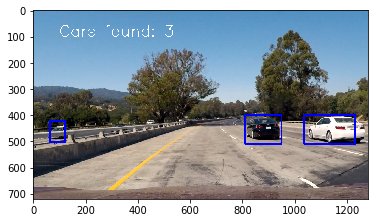

In [15]:
heatmaps = []
img = mpimg.imread("./test_images/test1.jpg")
img = process_image(img)
plt.imshow(img)
plt.show()

In [16]:
heatmaps = []
clip_output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")
clip_processing = clip.fl_image(process_image)
%time clip_processing.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:36<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 36.1 s, sys: 148 ms, total: 36.2 s
Wall time: 36.9 s


In [17]:
heatmaps = []
clip_output = 'project_video_output-SVM.mp4'
clip = VideoFileClip("project_video.mp4")
clip_processing = clip.fl_image(process_image)
%time clip_processing.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video project_video_output-SVM.mp4
[MoviePy] Writing video project_video_output-SVM.mp4


100%|█████████▉| 1260/1261 [20:14<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output-SVM.mp4 

CPU times: user 20min 16s, sys: 2.95 s, total: 20min 18s
Wall time: 20min 15s
